## Set initiallization

In [1]:
import numpy as np

# Given data set
d_x = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
d_y = np.array([0.0, 0.59, -0.95, 0.95, -0.59, 0])

# Periodic kernel function
def kernel_function(x, x_, sigma_f=1, l=1, T=0.5):
    K = np.zeros((len(x), len(x_)))

    # Generate covariance matrix
    for i in range(len(x)):
        for j in range(len(x_)):
            K[i,j] = sigma_f**2 * np.exp(-(2/l**2) * (np.sin(np.pi * abs(x[i]-x_[j]) / T))**2)

    return K

## Draw the contour line

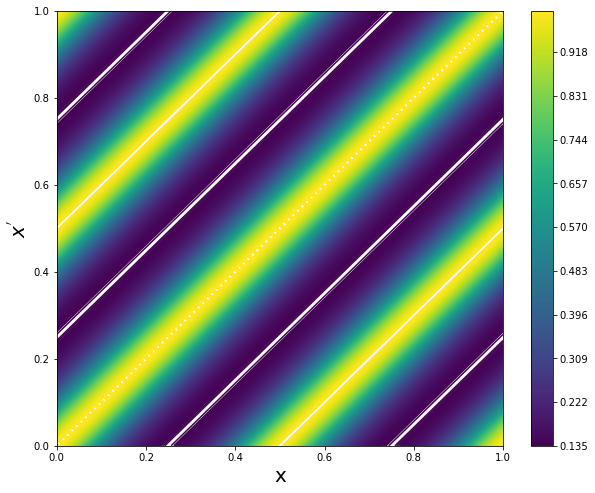

In [40]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

# Create sample points
x = np.linspace(0, 1, 100)

# Generate covirance matrix
z_sample = kernel_function(x, x)

# Draw contour line
plt.contour(x, x, z_sample, 1000)
plt.colorbar()
plt.xlabel('x', fontsize=20)
plt.ylabel('$x^{\'}$', fontsize=20)
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.show()


## Prior random samples

Unfinished

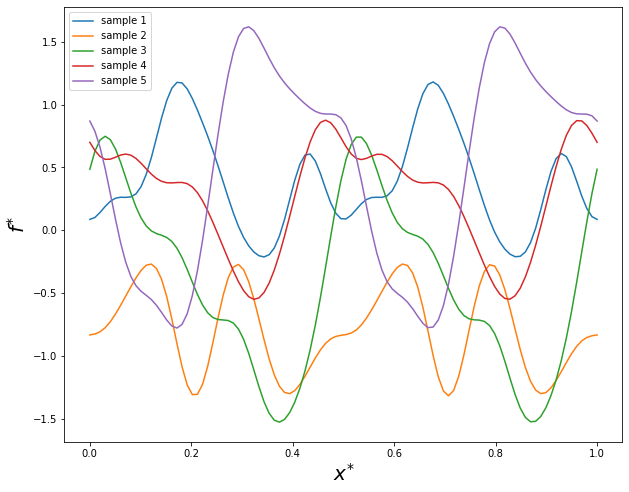

'\nVerify samples are periodic!!!!!!!!!!\n'

In [31]:
x_star = np.linspace(0, 1, 100)

# Generate covirance matrix from (x*, x*)
k_star = kernel_function(x_star, x_star)
mean_star = np.zeros(len(x_star))

sample_num = 5
f_star = np.random.multivariate_normal(mean_star, k_star, size=sample_num)

fig = plt.figure()
ax = plt.axes()

for i in range(sample_num):
    plt.plot(x_star, f_star[i], label='sample ' + str(i+1))

plt.legend()
plt.xlabel('$x^{*}$', fontsize=20)
plt.ylabel('$f^{*}$', fontsize=20)
plt.show()


'''
Verify samples are periodic!!!!!!!!!!
'''



## The posterior predictive distribution

$$
\textbf{f}_* | \textbf{y}, X, X_* \sim \mathcal{N}\bigg(K(X_*, X)\big(K(X, X) + \sigma^2I\big)^{-1}\textbf{y}, K(X_*, X_*)-K(X_*, X)\big(K(X, X) + \sigma^2I\big)^{-1}K(X, X_*)\bigg)
$$


In [33]:
# Define the posterior distribution function
def posterior_distribution(x, y, x_star, sigma=0.01):
    # Compute mean
    mean = kernel_function(x_star, x) @ np.linalg.inv(kernel_function(x, x) + sigma**2 * np.identity(len(x))) @ y

    # Compute covariance matrix
    covariance = kernel_function(x_star, x_star) - \
                kernel_function(x_star, x) @ np.linalg.inv(kernel_function(x, x) + sigma**2 * np.identity(len(x))) \
                @ kernel_function(x, x_star)

    return mean, covariance


mean, covariance = posterior_distribution(d_x, d_y, x_star)
sample = 1000
f_pos = np.random.multivariate_normal(mean, covariance, size=sample)

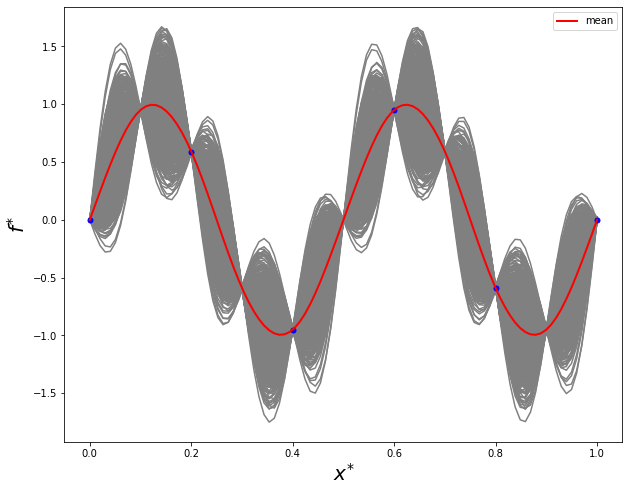

In [34]:
fig = plt.figure()
ax = plt.axes()

for i in range(sample):
    ax.plot(x_star, f_pos[i], 'grey')
ax.plot(d_x, d_y, 'b.', markersize=10)
ax.plot(x_star, mean, 'r', linewidth=2.0, label='mean')

ax.legend()
ax.set_xlabel('$x^{*}$', fontsize=20)
ax.set_ylabel('$f^{*}$', fontsize=20)
# plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.show()

## Plot the contour line for posterior covariance matrix

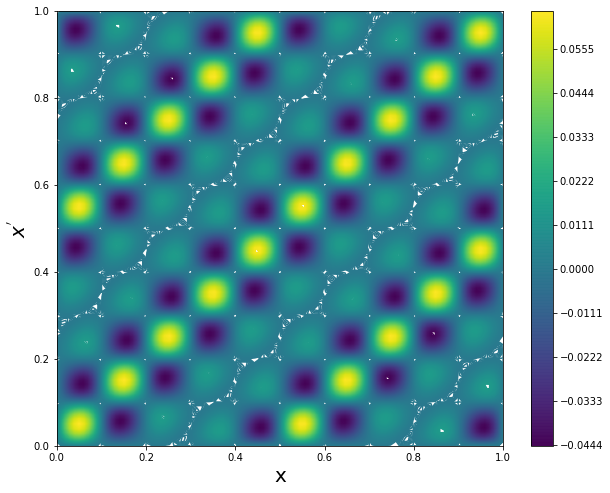

In [39]:
# Draw contour line
plt.contour(x_star, x_star, covariance, 1000)
plt.colorbar()
plt.xlabel('x', fontsize=20)
plt.ylabel('$x^{\'}$', fontsize=20)
plt.show()

## Gaussion process regression by Cholesky decomposition

In [12]:
def GPR_cholesky(x, y, x_star, sigma=0.01):
    K = kernel_function(x, x)

    # Cholesky decomposition of (K(x, x) + sigma^2 I)
    K_noise = K + sigma**2 * np.identity(len(x))
    L = np.linalg.cholesky(K_noise)
    alpha = np.linalg.solve(np.transpose(L), (np.linalg.solve(L, y)))

    mean_cho = np.zeros(len(x_star))
    variance_cho = np.zeros(len(x_star))

    for i in range(len(x_star)):
        k_star = kernel_function(x, [x_star[i]])

        # Compute mean value
        f_star_ = k_star.T @ alpha

        # Compute covariance value
        v = np.linalg.solve(L, k_star)
        variance = kernel_function(x=[x_star[i]], x_=[x_star[i]]) - v.T @ v

        mean_cho[i] = f_star_
        variance_cho[i] = variance
    
    return mean_cho, variance_cho


sigma = 0.01
mean_cho, variance_cho = GPR_cholesky(d_x, d_y, x_star)

## Plot posterior mean with +- 2 posterior standard deviations

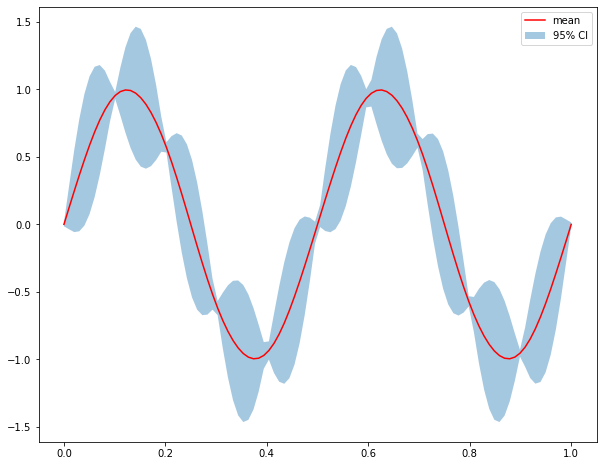

In [30]:
# Create 2*posterior standard deviation (2 * Variance^0.5)
pos_std = 2 * variance_cho**(0.5)

plt.plot(x_star, mean_cho, 'r', label='mean')
plt.fill_between(x_star, (mean_cho-pos_std), (mean_cho+pos_std), alpha=.4, label='95% CI')
plt.legend()
plt.show()
